# Face verification using Siamese Networks

In this lab, we will look at a simple face verification system using a Siamese network. We will use the LFW dataset, which is a collection of face images of famous people. We will train a Siamese network to recognize whether two images belong to the same person or not.

### Goals
- train a network for face similarity using siamese networks
- work data augmentation, generators and hard negative mining
- use the model on your picture (if you like)


### Dataset

- We will be using Labeled Faces in the Wild (LFW) dataset available openly at [http://vis-www.cs.umass.edu/lfw/](http://vis-www.cs.umass.edu/lfw/).
- For computing purposes, we'll only restrict ourselves to a subpart of the dataset. You're welcome to train on the whole dataset on GPU, by setting `USE_SUBSET=False` in the following cells,
- We will also load pretrained weights


In [1]:
import os.path as op
from urllib.request import urlretrieve
import tarfile
import time

URL = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
FILENAME = "lfw-deepfunneled.tgz"

def reporthook(blocknum, blocksize, totalsize):
    readsofar = blocknum * blocksize
    if totalsize > 0:
        percent = readsofar * 1e2 / totalsize
        bar_length = 50
        filled_length = int(percent * bar_length / 100)
        bar = '=' * filled_length + '-' * (bar_length - filled_length)
        print(f"\rDownloading: [{bar}] {percent:.1f}%", end="")
    else:
        print("read %d\n" % readsofar, end="")

if not op.exists(FILENAME):
    print('Downloading %s to %s...' % (URL, FILENAME))
    urlretrieve(URL, FILENAME, reporthook=reporthook)

if not op.exists("lfw"):
    print('\nExtracting image files...')
    with tarfile.open("lfw-deepfunneled.tgz") as tar:
        num_members = len(list(tar.getmembers()))  # Get total for basic progress
        extract_count = 0
        for member in tar.getmembers():
            tar.extract(member, "lfw")
            extract_count += 1
            percent = extract_count * 100 / num_members
            print(f"\rExtracting: {percent:.1f}%", end="")

print("\nDone!")


Done!


In [2]:
import os
import random
import itertools
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
import numpy as np
import matplotlib.pyplot as plt

2024-08-02 13:28:15.129727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Processing the dataset

The dataset consists of folders corresponding to each identity. The folder name is the name of the person.
We map each class (identity) to an integer id, and build mappings as dictionaries `name_to_classid` and `classid_to_name`

In [3]:
PATH = "lfw/lfw-deepfunneled/"
USE_SUBSET = True

In [4]:
dirs = sorted(os.listdir(PATH))
if USE_SUBSET:
    dirs = dirs[:500]

name_to_classid = {d: i for i, d in enumerate(dirs)}
classid_to_name = {v: k for k, v in name_to_classid.items()}
num_classes = len(name_to_classid)

print(f'Number of classes (i.e. people): {num_classes}')

Number of classes (i.e. people): 500


In each directory, there is one or more images corresponding to the identity. We map each image path with an integer id, then build a few dictionaries:
- mappings from imagepath and image id: `path_to_id` and `id_to_path`
- mappings from class id to image ids: `classid_to_ids` and `id_to_classid`

In [5]:
# read all directories
img_paths = {c: [PATH + subfolder + "/" + img
                 for img in sorted(os.listdir(PATH + subfolder))]
             for subfolder, c in name_to_classid.items()}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_id = {v: k for k, v in enumerate(all_images_path)}
id_to_path = {v: k for k, v in path_to_id.items()}

In [6]:
all_images_path[:10]

['lfw/lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg',
 'lfw/lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg',
 'lfw/lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg',
 'lfw/lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg',
 'lfw/lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg',
 'lfw/lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg',
 'lfw/lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg',
 'lfw/lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg',
 'lfw/lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg',
 'lfw/lfw-deepfunneled/Aaron_Pena/Aaron_Pena_0001.jpg']

In [7]:
len(all_images_path)

1155

In [8]:
# build mappings between images and class
classid_to_ids = {k: [path_to_id[path] for path in v] for k, v in img_paths.items()}
id_to_classid = {v: c for c, imgs in classid_to_ids.items() for v in imgs}
dict(list(id_to_classid.items())[0:13])

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 5,
 7: 5,
 8: 5,
 9: 6,
 10: 7,
 11: 7,
 12: 8}

The following histogram shows the number of images per class: there are many classes with only one image. Since we need at least two examples of an identity to build a positive pair, these classes will only be used for negative pairs.

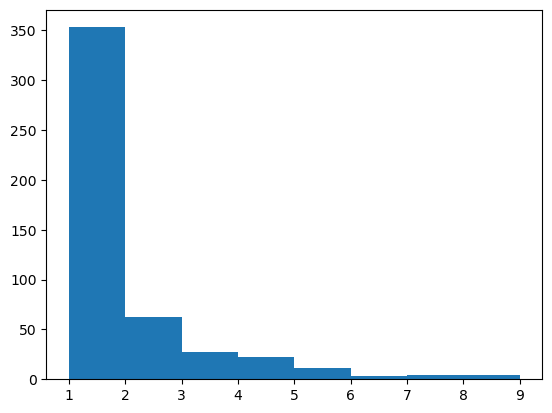

In [9]:
plt.hist([len(v) for k, v in classid_to_ids.items()], bins=range(1, 10))
plt.show()

In [10]:
np.median([len(ids) for ids in classid_to_ids.values()])

1.0

In [11]:
[(classid_to_name[x], len(classid_to_ids[x]))
 for x in np.argsort([len(v) for k, v in classid_to_ids.items()])[::-1][:10]]

[('Ariel_Sharon', 77),
 ('Arnold_Schwarzenegger', 42),
 ('Alejandro_Toledo', 39),
 ('Andre_Agassi', 36),
 ('Alvaro_Uribe', 35),
 ('Atal_Bihari_Vajpayee', 24),
 ('Amelie_Mauresmo', 21),
 ('Angelina_Jolie', 20),
 ('Abdullah_Gul', 19),
 ('Andy_Roddick', 15)]

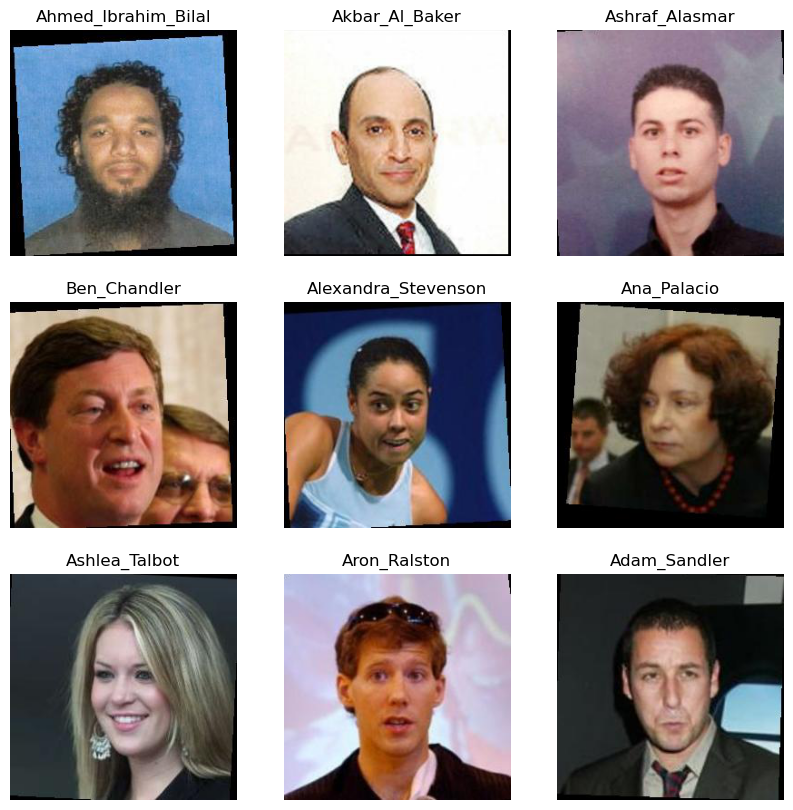

In [12]:
# Display some images
from random import choice

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    class_id = choice(list(classid_to_ids.keys()))
    img_id = choice(classid_to_ids[class_id])
    img = plt.imread(id_to_path[img_id])
    ax.imshow(img)
    ax.set_title(classid_to_name[class_id])
    ax.axis('off')
plt.show()

### Siamese nets

A siamese net takes as input two images $x_1$ and $x_2$ and outputs a single value which corresponds to the similarity between $x_1$ and $x_2$.



In order to train such a system, we need to create pairs of positive examples and negative examples. We will use the following two methods to build the pairs:

In [13]:
# Build pairs of positive image ids for a given classid
def build_pos_pairs_for_id(classid, max_num=70):
    imgs = classid_to_ids[classid]

    if len(imgs) == 1:
        return []

    pos_pairs = list(itertools.combinations(imgs, 2))

    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

In [14]:
# Build pairs of negative image ids for a given classid
def build_neg_pairs_for_id(classid, classes, max_num=3):
    imgs = classid_to_ids[classid]
    neg_classes_ids = random.sample(classes, max_num+1)

    if classid in neg_classes_ids:
        neg_classes_ids.remove(classid)

    neg_pairs = []
    for id2 in range(max_num):
        img1 = imgs[random.randint(0, len(imgs) - 1)]
        imgs2 = classid_to_ids[neg_classes_ids[id2]]
        img2 = imgs2[random.randint(0, len(imgs2) - 1)]
        neg_pairs += [(img1, img2)]

    return neg_pairs

Let's build positive and a negative pairs for class 5:

In [15]:
build_pos_pairs_for_id(5, max_num=10)

[(5, 7), (5, 6), (5, 8), (6, 8), (6, 7), (7, 8)]

In [16]:
build_neg_pairs_for_id(5, list(range(num_classes)), max_num=6)

[(8, 336), (8, 307), (8, 371), (5, 283), (8, 198), (6, 731)]

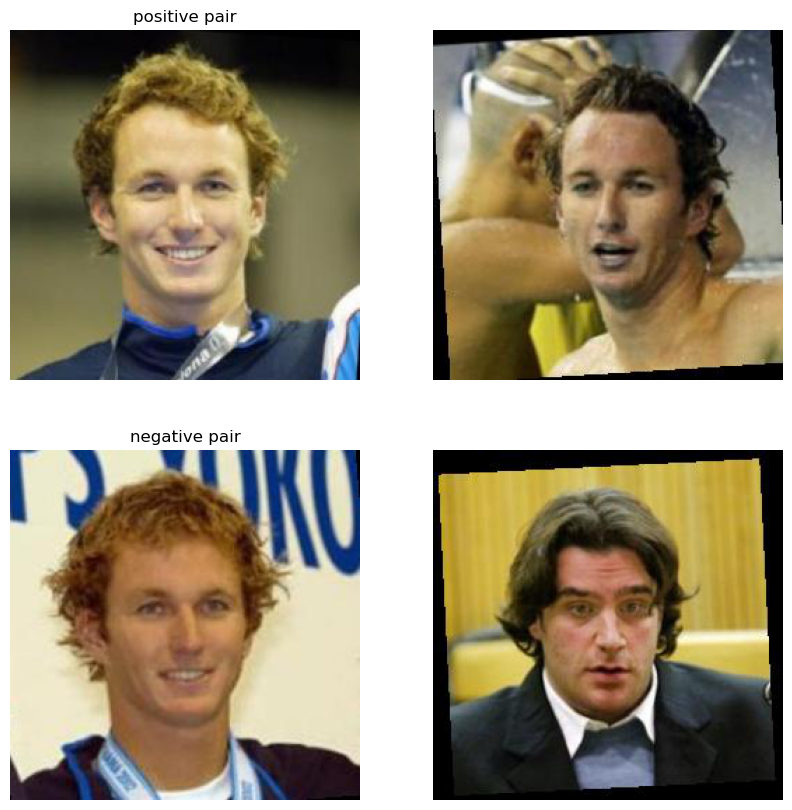

In [17]:
# Visualize a positive pair and a negative pair
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

img1, img2 = build_pos_pairs_for_id(5, max_num=1)[0]

ax[0, 0].imshow(plt.imread(id_to_path[img1]))
ax[0, 0].set_title("positive pair")
ax[0, 0].axis('off')

ax[0, 1].imshow(plt.imread(id_to_path[img2]))
ax[0, 1].axis('off')

img1, img2 = build_neg_pairs_for_id(5, list(range(num_classes)), max_num=1)[0]

ax[1, 0].imshow(plt.imread(id_to_path[img1]))
ax[1, 0].set_title("negative pair")
ax[1, 0].axis('off')

ax[1, 1].imshow(plt.imread(id_to_path[img2]))
ax[1, 1].axis('off')

plt.show()

Now that we have a way to compute the pairs, let's load all the possible JPEG-compressed image files into a single numpy array in RAM. There are around 1000 images, so 100MB of RAM will be used, which should be fine.

In [18]:
from skimage.io import imread
from skimage.transform import resize

def resize100(img): # resize to 100x100
    return resize(
        img, (100, 100), preserve_range=True, mode='reflect', anti_aliasing=True
    )[20:80, 20:80, :]


def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        all_imgs += [np.expand_dims(resize100(imread(path)), 0)]
    return np.vstack(all_imgs)

In [19]:
all_imgs = open_all_images(id_to_path)
all_imgs.shape

(1155, 60, 60, 3)

In [20]:
print(f"{all_imgs.nbytes / 1e6} MB")

99.792 MB


The following function builds a large number of positives/negatives pairs (train and test)

In [21]:
from sklearn.model_selection import train_test_split

def generate_data_pairs():
    """Generates (x1, x2, y) data pairs for all classes."""

    all_input_1 = []
    all_input_2 = []
    all_labels = []

    for class_id in range(num_classes):
        positive_pairs = build_pos_pairs_for_id(class_id)
        negative_pairs = build_neg_pairs_for_id(class_id, list(range(num_classes)))

        for pair in positive_pairs:
            all_input_1.append(pair[0])
            all_input_2.append(pair[1])
            all_labels.append(1)

        for pair in negative_pairs:
            all_input_1.append(pair[0])
            all_input_2.append(pair[1])
            all_labels.append(0)

    return np.array(all_input_1), np.array(all_input_2), np.array(all_labels)

def split_into_train_test(X1, X2, Y, train_data_ratio=0.8):
    """Splits data into training and testing sets."""

    X1_train, X1_test, X2_train, X2_test, Y_train, Y_test = train_test_split(
        X1, X2, Y, test_size=1 - train_data_ratio
    )
    return X1_train, X2_train, Y_train, X1_test, X2_test, Y_test

In [22]:
X1, X2, Y = generate_data_pairs()
X1_train, X2_train, Y_train, X1_test, X2_test, Y_test = split_into_train_test(X1, X2, Y)

In [23]:
X1_train.shape, X2_train.shape, Y_train.shape

((2466,), (2466,), (2466,))

In [24]:
np.mean(Y_train)

0.5178426601784266

In [25]:
X1_test.shape, X2_test.shape, Y_test.shape

((617,), (617,), (617,))

In [26]:
np.mean(Y_test)

0.4829821717990275

**Data augmentation and generator**

We're building a generator, which will modify images through data augmentation on the fly. This is useful when we have a large dataset and we don't want to store all the augmented images in memory. We will use the `ImageDataGenerator` from Keras to perform the augmentation. We will use the generator to train the model.

You can add more image augmentations to the generator, such as rotation, zooming, etc. The goal is to make the model more robust to different lighting conditions, rotations, etc. Have a look at the documentation [here](https://keras.io/preprocessing/image/).

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class Generator(tf.keras.utils.Sequence):

    def __init__(self, X1, X2, Y, batch_size, all_imgs):
        self.batch_size = batch_size
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]

        # Create ImageDataGenerator for augmentation
        self.image_datagen = ImageDataGenerator(
            horizontal_flip=True  # Replace with other desired augmentations
        )

    def __len__(self):
        return self.num_samples // self.batch_size

    def __getitem__(self, batch_index):
        """This method returns the `batch_index`-th batch of the dataset."""

        low_index = batch_index * self.batch_size
        high_index = (batch_index + 1) * self.batch_size

        # Fetch image data
        imgs1 = self.imgs[self.X1[low_index:high_index]]
        imgs2 = self.imgs[self.X2[low_index:high_index]]
        targets = self.Y[low_index:high_index]

        # Apply augmentation in batches
        imgs1 = self.image_datagen.flow(imgs1, batch_size=self.batch_size, shuffle=False).next()
        imgs2 = self.image_datagen.flow(imgs2, batch_size=self.batch_size, shuffle=False).next()

        return ([imgs1, imgs2], targets)

In [27]:
gen = Generator(X1_train, X2_train, Y_train, 32, all_imgs)

In [28]:
print("Number of batches: {}".format(len(gen)))

Number of batches: 77


In [29]:
[x1, x2], y = gen[0]

x1.shape, x2.shape, y.shape

((32, 60, 60, 3), (32, 60, 60, 3), (32,))

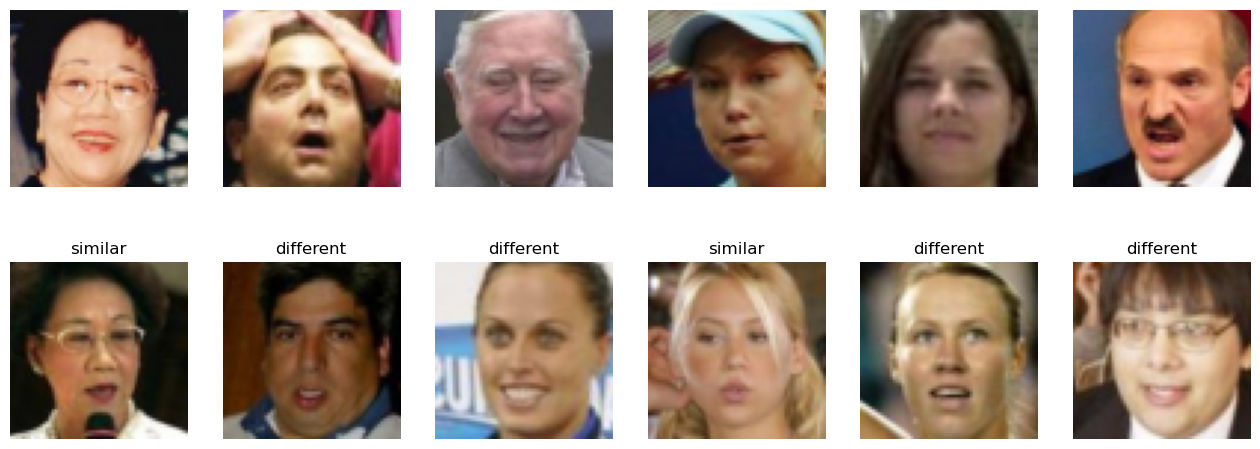

In [30]:
plt.figure(figsize=(16, 6))

for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(x1[i] / 255)
    plt.axis('off')

for i in range(6):
    plt.subplot(2, 6, i + 7)
    plt.imshow(x2[i] / 255)
    if y[i]==1.0:
        plt.title("similar")
    else:
        plt.title("different")
    plt.axis('off')

plt.show()

**Exercise**
- Add your own data augmentations in the process.
- Be careful not to make the task to difficult, and to add meaningful augmentations;
- Re-run the generator plot above to check whether the image pairs look not too distorted to recognize the identities.

** Test images **

- In addition to our generator, we need test images, unaffected by the augmentation:

In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class Generator(tf.keras.utils.Sequence):
    def __init__(self, X1, X2, Y, batch_size, all_imgs):
        self.batch_size = batch_size
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]

        # Create ImageDataGenerator for augmentation
        self.image_datagen = ImageDataGenerator(
            horizontal_flip=True,  # Randomly flip images horizontally
            rotation_range=10,     # Rotate images within 10 degrees
            width_shift_range=0.1, # Shift images horizontally by 10% of width
            height_shift_range=0.1, # Shift images vertically by 10% of height
            zoom_range=0.1,        # Zoom images by up to 10%
            brightness_range=[0.8, 1.2] # Vary brightness
        )

    def __len__(self):
        return self.num_samples // self.batch_size

    def __getitem__(self, batch_index):
        """This method returns the `batch_index`-th batch of the dataset."""
        low_index = batch_index * self.batch_size
        high_index = (batch_index + 1) * self.batch_size

        # Fetch image data
        imgs1 = self.imgs[self.X1[low_index:high_index]]
        imgs2 = self.imgs[self.X2[low_index:high_index]]
        targets = self.Y[low_index:high_index]

        # Apply augmentation in batches
        imgs1 = self.image_datagen.flow(imgs1, batch_size=self.batch_size, shuffle=False).next()
        imgs2 = self.image_datagen.flow(imgs2, batch_size=self.batch_size, shuffle=False).next()

        return ([imgs1, imgs2], targets)

# Assume test_X1 and test_X2 are defined as follows:
# Load test images without any augmentation
test_X1 = all_imgs[X1_test]
test_X2 = all_imgs[X2_test]

print("Test X1 shape:", test_X1.shape)
print("Test X2 shape:", test_X2.shape)


Test X1 shape: (617, 60, 60, 3)
Test X2 shape: (617, 60, 60, 3)


## Simple convolutional model

We will build a simple convolutional model which takes an image and outputs a vector of a fixed dimension. We will use this model as a shared model for the two inputs of the siamese network. For the network, we need to define a custom loss function (included in the model definition) and a custom accuracy function, which we will use to monitor the training process.

In [32]:
@tf.function
def accuracy_sim(y_true, y_pred, threshold=0.5):
    y_thresholded = tf.cast(y_pred > threshold, "float32")
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_thresholded), "float32"))

**Exercise**

Complete the following Siamese model. The model should take two inputs, run them through the shared convolutional model, and then compute the similarity between the two vectors using a custom layer.    

In [36]:
#Solution
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model

def build_shared_conv(input_shape=(60, 60, 3)):
    """Builds a simple shared convolutional model."""
    inputs = Input(shape=input_shape)

    # Add some convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)

    # Create a model that outputs the flattened layer
    return Model(inputs, x)

def build_siamese_model(shared_conv, input_shape=(60, 60, 3)):
    """Builds a siamese model with the given shared convolutional base."""

    # Two input layers for the two images
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)
    
    # Process both inputs through the shared convolutional base
    output_1 = shared_conv(input_1)
    output_2 = shared_conv(input_2)

    # Compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([output_1, output_2])

    # Dense layer with a sigmoid activation to predict similarity
    output = Dense(1, activation='sigmoid')(L1_distance)

    # Create the Siamese model
    model = Model(inputs=[input_1, input_2], outputs=output)
    return model

# Build the shared convolutional model
shared_conv = build_shared_conv()

# Build the Siamese model using the shared convolutional model
siamese_model = build_siamese_model(shared_conv)

# Summary of the Siamese model
siamese_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 60, 60, 3)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 60, 60, 3)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 6272)         93248       ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 6272)         0           ['model_2[0][0]',          

In [38]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[accuracy_sim])

We can now fit the model and checkpoint it to keep the best version. We can expect to get a model with around 0.75 as "accuracy_sim" on the validation set:

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

best_model_cb = ModelCheckpoint(
    "siamese_checkpoint",
    monitor='val_accuracy_sim',
    save_best_only=True, verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor='val_accuracy_sim',
    patience=5, verbose=1
)

In [41]:
siamese_model.fit(
          gen,
          epochs=50,
          validation_data=([test_X1, test_X2], Y_test),
          callbacks=[best_model_cb, early_stopping_cb]
          )

Epoch 1/50


2024-08-02 13:39:11.313338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


77/77 [==============================] - ETA: 0s - loss: 1.4944 - accuracy_sim: 0.5690
Epoch 1: val_accuracy_sim improved from -inf to 0.63316, saving model to siamese_checkpoint


INFO:tensorflow:Assets written to: siamese_checkpoint/assets


INFO:tensorflow:Assets written to: siamese_checkpoint/assets


77/77 [==============================] - 21s 245ms/step - loss: 1.4944 - accuracy_sim: 0.5690 - val_loss: 0.6517 - val_accuracy_sim: 0.6332
Epoch 2/50
77/77 [==============================] - ETA: 0s - loss: 0.6014 - accuracy_sim: 0.6749
Epoch 2: val_accuracy_sim did not improve from 0.63316
77/77 [==============================] - 16s 202ms/step - loss: 0.6014 - accuracy_sim: 0.6749 - val_loss: 0.6472 - val_accuracy_sim: 0.6332
Epoch 3/50
77/77 [==============================] - ETA: 0s - loss: 0.5635 - accuracy_sim: 0.7001
Epoch 3: val_accuracy_sim improved from 0.63316 to 0.70851, saving model to siamese_checkpoint


INFO:tensorflow:Assets written to: siamese_checkpoint/assets


INFO:tensorflow:Assets written to: siamese_checkpoint/assets


77/77 [==============================] - 17s 222ms/step - loss: 0.5635 - accuracy_sim: 0.7001 - val_loss: 0.5951 - val_accuracy_sim: 0.7085
Epoch 4/50
77/77 [==============================] - ETA: 0s - loss: 0.5090 - accuracy_sim: 0.7488
Epoch 4: val_accuracy_sim improved from 0.70851 to 0.72240, saving model to siamese_checkpoint


INFO:tensorflow:Assets written to: siamese_checkpoint/assets


INFO:tensorflow:Assets written to: siamese_checkpoint/assets


77/77 [==============================] - 21s 272ms/step - loss: 0.5090 - accuracy_sim: 0.7488 - val_loss: 0.5468 - val_accuracy_sim: 0.7224
Epoch 5/50
77/77 [==============================] - ETA: 0s - loss: 0.4747 - accuracy_sim: 0.7727
Epoch 5: val_accuracy_sim improved from 0.72240 to 0.75608, saving model to siamese_checkpoint


INFO:tensorflow:Assets written to: siamese_checkpoint/assets


INFO:tensorflow:Assets written to: siamese_checkpoint/assets


77/77 [==============================] - 17s 223ms/step - loss: 0.4747 - accuracy_sim: 0.7727 - val_loss: 0.5332 - val_accuracy_sim: 0.7561
Epoch 6/50
77/77 [==============================] - ETA: 0s - loss: 0.4119 - accuracy_sim: 0.8036
Epoch 6: val_accuracy_sim improved from 0.75608 to 0.77951, saving model to siamese_checkpoint


INFO:tensorflow:Assets written to: siamese_checkpoint/assets


INFO:tensorflow:Assets written to: siamese_checkpoint/assets


77/77 [==============================] - 18s 235ms/step - loss: 0.4119 - accuracy_sim: 0.8036 - val_loss: 0.4749 - val_accuracy_sim: 0.7795
Epoch 6: early stopping


In [44]:
from tensorflow.keras.models import load_model

siamese_model = load_model("siamese_checkpoint", custom_objects={"accuracy_sim": accuracy_sim})

**Exercise**

Finding the most similar images

- Run the shared_conv model on all images;
- build a `most_sim` function which returns the most similar vectors to a given vector.

In [45]:
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list
path_to_id = {v: k for k, v in enumerate(all_images_path)}
id_to_path = {v: k for k, v in path_to_id.items()}
all_imgs = open_all_images(id_to_path)

# Actually compute the similarities
emb = shared_conv(all_imgs)
emb = emb / np.linalg.norm(emb, axis=-1, keepdims=True)

def most_sim(x, emb, topn=4):
    sims = np.dot(emb, x)
    ids = np.argsort(sims)[::-1]
    return [(id, sims[id]) for id in ids[:topn]]

**Most similar faces **

The following enables to display an image alongside with most similar images:

- The results are weak, first because of the size of the dataset
- Also, the network can be greatly improved

In [46]:
def display(img):
    img = img.astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

query: Ahmed_Chalabi 120
nearest matches
Ahmed_Chalabi 120 0.9999998


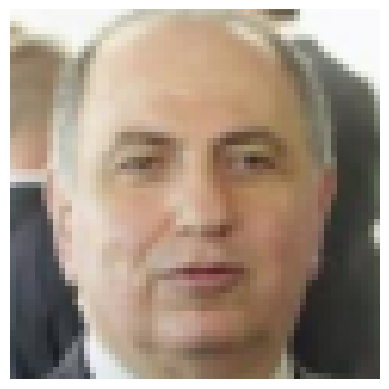

Ari_Fleischer 802 0.9354195


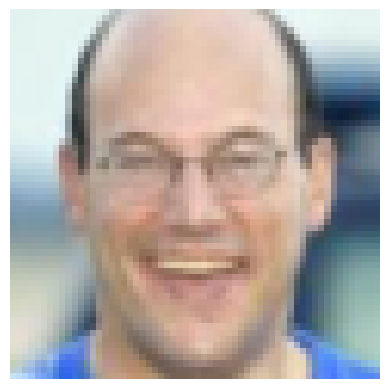

Alexander_Losyukov 314 0.93528605


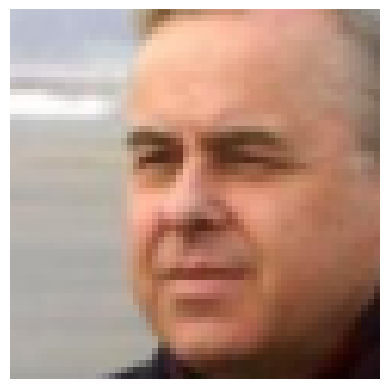

Ari_Fleischer 800 0.9352464


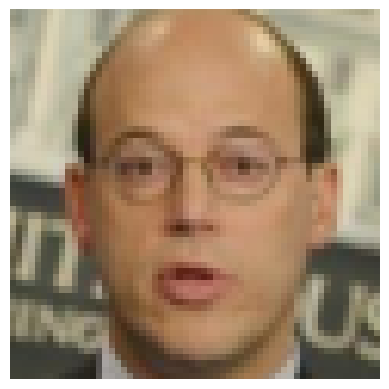

In [47]:
interesting_classes = list(filter(lambda x: len(x[1]) > 4, classid_to_ids.items()))
class_id = random.choice(interesting_classes)[0]

query_id = random.choice(classid_to_ids[class_id])
print("query:", classid_to_name[class_id], query_id)
# display(all_imgs[query_id])

print("nearest matches")
for result_id, sim in most_sim(emb[query_id], emb):
    class_name = classid_to_name.get(id_to_classid.get(result_id))
    print(class_name, result_id, sim)
    display(all_imgs[result_id])

Note that this model is still underfitting, even when running queries against the training set. Even if the results are not correct, the mistakes often seem to "make sense" though.

Running a model to convergence on higher resolution images, possibly with a deeper and wider convolutional network might yield better results. In the next notebook we will try with a better loss and with hard negative mining.

## Using the model on your picture

You can use the model to find the most similar faces to your own picture. Upload your picture to Colab (if using) on the left, and run the code below:

In [55]:
# For WSL or Linux-based environment
image_path = "/mnt/c/Users/josem/Downloads/UofT/deep_learning/01_materials/labs/images/jm.jpeg"


1/1 [==============================] - 0s 97ms/step


Nearest matches
Amram_Mitzna 494 0.7958994


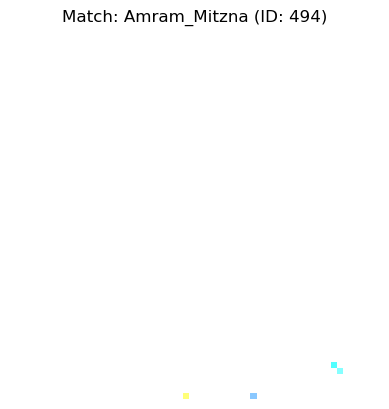

Amanda_Marsh 453 0.78651524


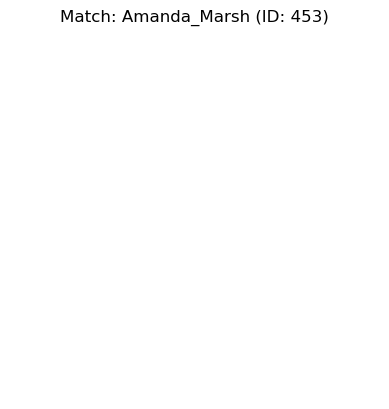

Andre_Agassi 553 0.78638184


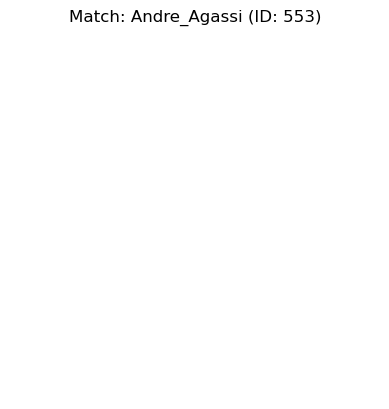

Bernard_Ebbers 1153 0.78524137


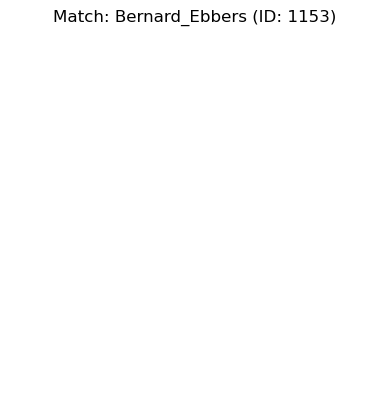

Adrian_Murrell 94 0.78426355


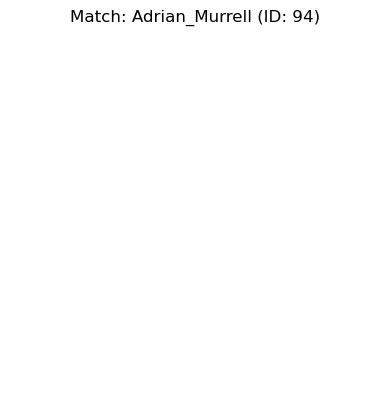

In [56]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import os

# Define a function to resize the image
def resize100(image, target_size=(60, 60)):
    """Resize the image to the target size."""
    return resize(image, target_size, anti_aliasing=True)

# Use an absolute path to specify the location of the image file
#image_path = r"C:\Users\josem\Downloads\UofT\deep_learning\01_materials\labs\images\jm.jpeg"

# Verify that the file exists
if not os.path.exists(image_path):
    raise FileNotFoundError(f"File not found: {image_path}")

# Load and preprocess your image
my_img = imread(image_path)
my_img = resize100(my_img)  # Resize to the target shape (60x60)
my_img = np.expand_dims(my_img, 0)  # Add batch dimension

# Compute the embedding using the shared convolutional model
my_emb = shared_conv.predict(my_img)

# Normalize the embedding
my_emb = my_emb / np.linalg.norm(my_emb, axis=-1, keepdims=True)
my_emb = my_emb[0]  # Remove batch dimension

# Define the function to find the most similar embeddings
def most_sim(my_emb, emb, top_k=5):
    """Finds the most similar embeddings."""
    similarities = np.dot(emb, my_emb)  # Assuming emb is normalized
    indices = np.argsort(-similarities)[:top_k]
    return [(idx, similarities[idx]) for idx in indices]

# Assume `emb` is your dataset's embeddings and class mappings are defined
print("Nearest matches")

for result_id, sim in most_sim(my_emb, emb):
    class_name = classid_to_name.get(id_to_classid.get(result_id))
    print(class_name, result_id, sim)
    # Display the matching image
    import matplotlib.pyplot as plt
    plt.imshow(all_imgs[result_id])
    plt.title(f"Match: {class_name} (ID: {result_id})")
    plt.axis('off')
    plt.show()


nearest matches
Amram_Mitzna 494 0.79589933


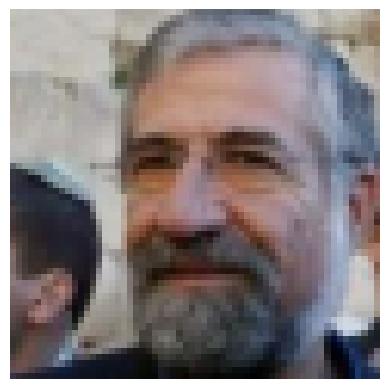

Amanda_Marsh 453 0.78651536


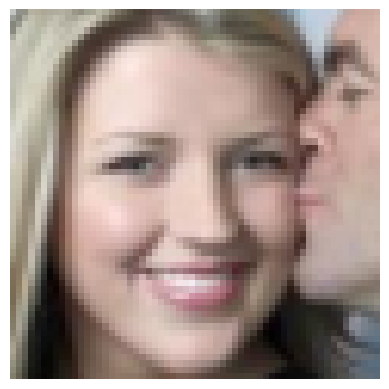

Andre_Agassi 553 0.7863818


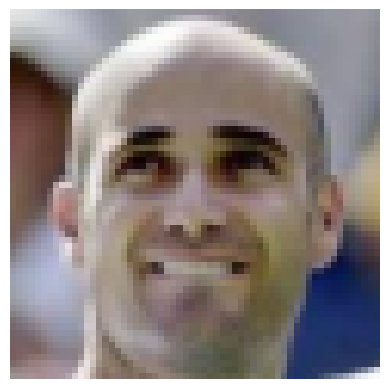

Bernard_Ebbers 1153 0.78524137


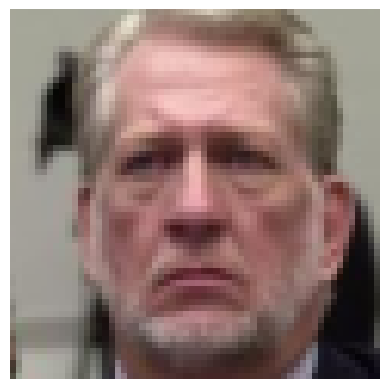

Adrian_Murrell 94 0.78426355


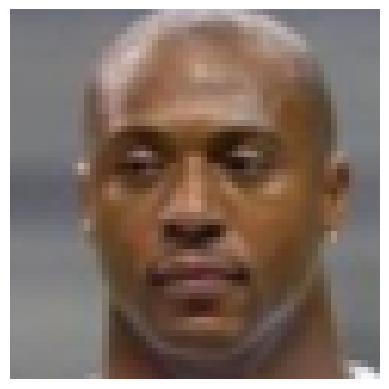

In [58]:
from skimage.io import imread

my_img = imread("/mnt/c/Users/josem/Downloads/UofT/deep_learning/01_materials/labs/images/jm.jpeg")
my_img = resize100(my_img)
my_img = np.expand_dims(my_img, 0)

my_emb = shared_conv(my_img)
my_emb = my_emb / np.linalg.norm(my_emb, axis=-1, keepdims=True)
my_emb = my_emb[0]

print("nearest matches")

for result_id, sim in most_sim(my_emb, emb):
    class_name = classid_to_name.get(id_to_classid.get(result_id))
    print(class_name, result_id, sim)
    display(all_imgs[result_id])